In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import Normalize
import glob

In [2]:
nc_files = sorted( glob.glob( r"C:\Users\locfa_v05v5qi\Documents\escadas_termohalinas\raw\Dataset\**\*.nc", recursive=True ) )

In [35]:
def subset_region(ds):
    # Ajustar longitudes se estiverem em 0–360
    if ds.lon.max() > 180:
        ds = ds.assign_coords(
            lon=((ds.lon + 180) % 360) - 180
        )

    # Criar máscara apenas para a dimensão n (perfis)
    mask = (
        (ds.lat <= 10) & (ds.lat >= -60) &
        (ds.lon >= -50) & (ds.lon <= -10)
    )

    if "Nobs" in ds.dims:
        ds = ds.isel(Nobs=mask)

    return ds
    
def check_staircase_exists(ml_h, gl_h): #verifica se os valores são fisicamente válidos (n só se existem)

    valid_ml = np.sum(~np.isnan(ml_h) & (ml_h > 0))
    valid_gl = np.sum(~np.isnan(gl_h) & (gl_h > 0))

    return (valid_ml >= 1) and (valid_gl >= 1)
    
def detect_staircases(ds):

    profile_dim = ds.lat.dims[0]
    n_profiles = ds.sizes[profile_dim] #p n ter problema d confundir "n" e "Nobs"

    staircase_sf = np.zeros(n_profiles, dtype=bool)
    staircase_dc = np.zeros(n_profiles, dtype=bool)

    for i in range(n_profiles):

        # =========================
        # SALT FINGER
        # =========================
        ml_mask_sf = ds.mask_ml_sf_layer.isel({profile_dim: i}) > 0
        gl_mask_sf = ds.mask_gl_sf_layer.isel({profile_dim: i}) > 0

        ml_h_sf = ds.ml_h.isel({profile_dim: i}).values[ml_mask_sf.values] #pega os valores onde ml_mask_sf é True 
        gl_h_sf = ds.gl_h.isel({profile_dim: i}).values[gl_mask_sf.values]

        if len(ml_h_sf) > 0 and len(gl_h_sf) > 0:
            staircase_sf[i] = check_staircase_exists(
                ml_h_sf, gl_h_sf
            )

        # =========================
        # DIFFUSIVE CONVECTION
        # =========================
        ml_mask_dc = ds.mask_ml_dc_layer.isel({profile_dim: i}) > 0
        gl_mask_dc = ds.mask_gl_dc_layer.isel({profile_dim: i}) > 0

        ml_h_dc = ds.ml_h.isel({profile_dim: i}).values[ml_mask_dc.values]
        gl_h_dc = ds.gl_h.isel({profile_dim: i}).values[gl_mask_dc.values]

        if len(ml_h_dc) > 0 and len(gl_h_dc) > 0:
            staircase_dc[i] = check_staircase_exists(
                ml_h_dc, gl_h_dc
            )

    ds["staircase_sf"] = (profile_dim, staircase_sf)
    ds["staircase_dc"] = (profile_dim, staircase_dc)

    return ds

def plot_triplet(data_all, data_sf, data_dc,
                 xlabel, title, bins=40, invert=False):

    # Converter para numpy 1D
    data_all = np.asarray(data_all).ravel()
    data_sf  = np.asarray(data_sf).ravel()
    data_dc  = np.asarray(data_dc).ravel()

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    axes[0].hist(data_all[~np.isnan(data_all)], bins=bins,
                 color="gray", alpha=0.7)
    axes[0].set_title("Geral")
    axes[0].set_xlabel(xlabel)

    axes[1].hist(data_sf[~np.isnan(data_sf)], bins=bins,
                 color="red", alpha=0.7)
    axes[1].set_title("Salt Finger")
    axes[1].set_xlabel(xlabel)

    axes[2].hist(data_dc[~np.isnan(data_dc)], bins=bins,
                 color="blue", alpha=0.7)
    axes[2].set_title("Diffusive Convection")
    axes[2].set_xlabel(xlabel)

    combined = np.concatenate([
        data_all[np.isfinite(data_all)],
        data_sf[np.isfinite(data_sf)],
        data_dc[np.isfinite(data_dc)]
    ])
    
    xmin = np.percentile(combined, 1)
    xmax = np.percentile(combined, 99)
    
    for ax in axes:
        ax.grid(alpha=0.3)
        ax.set_xlim(xmin, xmax)
        if invert:
            ax.invert_xaxis()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


In [21]:
#codigo vetorizado
first_all, first_sf, first_dc = [], [], []
last_all, last_sf, last_dc = [], [], []
h_all, h_sf, h_dc = [], [], []
n_all, n_sf, n_dc = [], [], []
lat_all, lat_sf, lat_dc = [], [], []

# =========================================================
# LOOP PRINCIPAL
# =========================================================

for file in nc_files:

    ds = xr.open_dataset(file)

    # 1) Recorte regional
    ds = subset_region(ds)

    if ds.sizes.get("Nobs", 0) == 0:
        continue

    # 2) Detectar staircases
    ds = detect_staircases(ds)

    # =========================
    # Dimensões
    # =========================
    profile_dim = ds.ml_p.dims[0]
    layer_dim   = ds.ml_p.dims[1]

    # =========================
    # Reconstruir top/bottom
    # =========================
    top = ds.ml_p - ds.ml_h / 2
    bottom = ds.ml_p + ds.ml_h / 2

    # =========================
    # Máscaras 2D
    # =========================
    sf_mask = ds.mask_ml_sf_layer > 0
    dc_mask = ds.mask_ml_dc_layer > 0
    all_mask = sf_mask | dc_mask

    # Perfis válidos (1D)
    valid_profiles = ds.staircase_sf | ds.staircase_dc

    # Expandir para 2D
    valid_profiles_2d = valid_profiles.broadcast_like(ds.ml_p)

    # Aplicar máscara combinada
    all_mask = all_mask & valid_profiles_2d
    sf_mask  = sf_mask & valid_profiles_2d
    dc_mask  = dc_mask & valid_profiles_2d

    # =========================
    # GERAL
    # =========================
    first_vals = top.where(all_mask).min(dim=layer_dim)
    last_vals  = bottom.where(all_mask).max(dim=layer_dim)

    first_vals = first_vals.values
    last_vals  = last_vals.values

    first_all.extend(first_vals[np.isfinite(first_vals)])
    last_all.extend(last_vals[np.isfinite(last_vals)])

    # Espessura
    h_vals = ds.ml_h.where(all_mask).values.flatten()
    h_all.extend(h_vals[np.isfinite(h_vals)])

    # Número de camadas por perfil
    n_vals = all_mask.sum(dim=layer_dim).values
    n_all.extend(n_vals[n_vals > 0])

    # Latitude
    lat_vals = ds.lat.where(valid_profiles).values
    lat_all.extend(lat_vals[np.isfinite(lat_vals)])

    # =========================
    # SALT FINGER
    # =========================
    first_sf_vals = top.where(sf_mask).min(dim=layer_dim).values
    last_sf_vals  = bottom.where(sf_mask).max(dim=layer_dim).values

    first_sf.extend(first_sf_vals[np.isfinite(first_sf_vals)])
    last_sf.extend(last_sf_vals[np.isfinite(last_sf_vals)])

    h_vals = ds.ml_h.where(sf_mask).values.flatten()
    h_sf.extend(h_vals[np.isfinite(h_vals)])

    n_vals = sf_mask.sum(dim=layer_dim).values
    n_sf.extend(n_vals[n_vals > 0])

    lat_vals = ds.lat.where(ds.staircase_sf).values
    lat_sf.extend(lat_vals[np.isfinite(lat_vals)])

    # =========================
    # DIFFUSIVE CONVECTION
    # =========================
    first_dc_vals = top.where(dc_mask).min(dim=layer_dim).values
    last_dc_vals  = bottom.where(dc_mask).max(dim=layer_dim).values

    first_dc.extend(first_dc_vals[np.isfinite(first_dc_vals)])
    last_dc.extend(last_dc_vals[np.isfinite(last_dc_vals)])

    h_vals = ds.ml_h.where(dc_mask).values.flatten()
    h_dc.extend(h_vals[np.isfinite(h_vals)])

    n_vals = dc_mask.sum(dim=layer_dim).values
    n_dc.extend(n_vals[n_vals > 0])

    lat_vals = ds.lat.where(ds.staircase_dc).values
    lat_dc.extend(lat_vals[np.isfinite(lat_vals)])

# =========================================================
# Converter tudo para numpy
# =========================================================

first_all = np.array(first_all)
first_sf  = np.array(first_sf)
first_dc  = np.array(first_dc)

last_all = np.array(last_all)
last_sf  = np.array(last_sf)
last_dc  = np.array(last_dc)

h_all = np.array(h_all)
h_sf  = np.array(h_sf)
h_dc  = np.array(h_dc)

n_all = np.array(n_all)
n_sf  = np.array(n_sf)
n_dc  = np.array(n_dc)

lat_all = np.array(lat_all)
lat_sf  = np.array(lat_sf)
lat_dc  = np.array(lat_dc)


In [25]:
#checagem pra ver se os dados estao certos
print("ALL:", len(first_all), np.isnan(first_all).sum())
print("SF :", len(first_sf), np.isnan(first_sf).sum())
print("DC :", len(first_dc), np.isnan(first_dc).sum())
print(np.sum(valid_profiles.values))

ALL: 17468 0
SF : 13850 0
DC : 10549 0
238


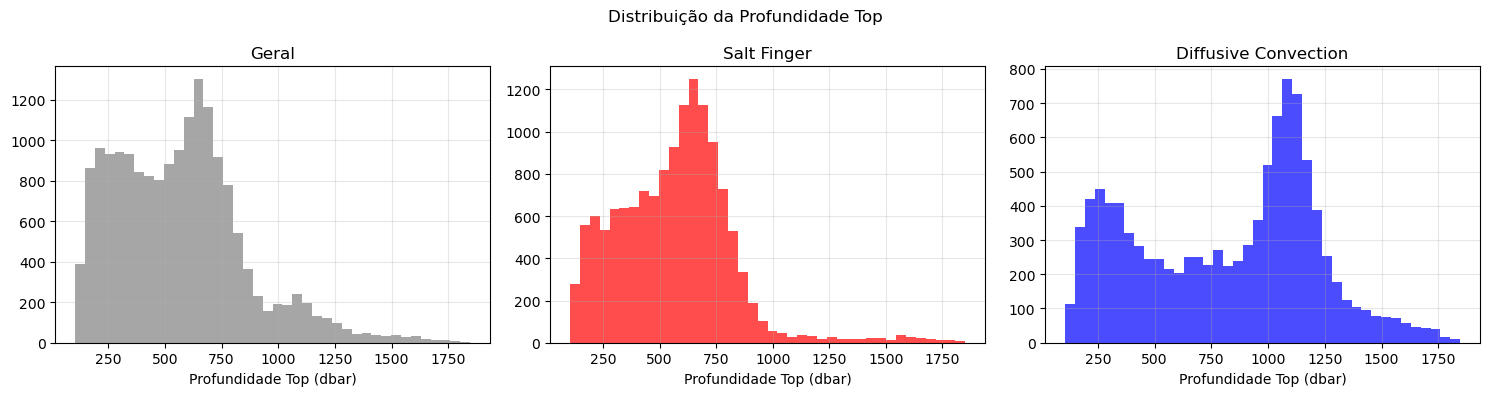

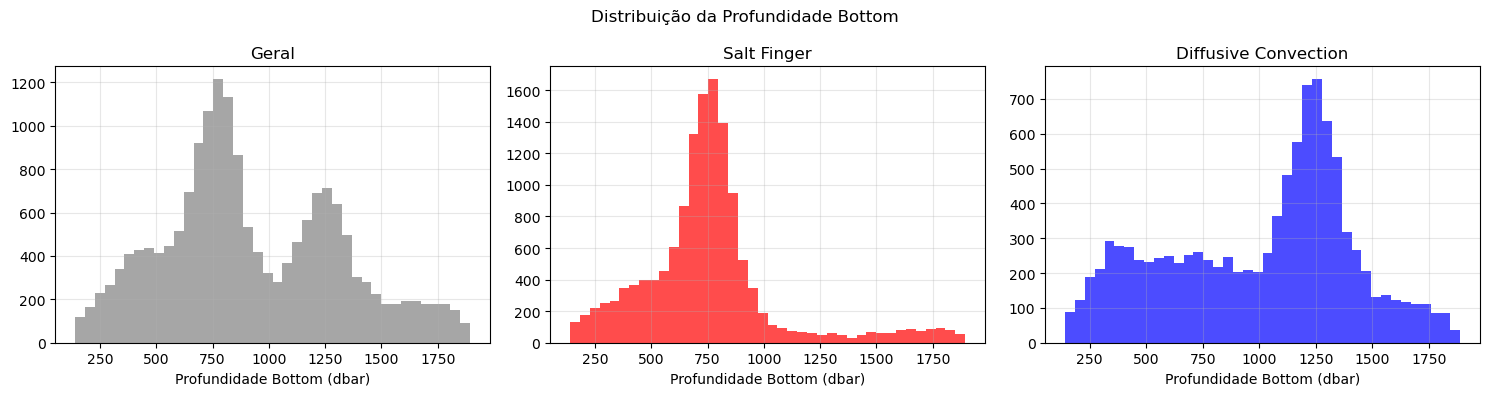

In [30]:
# FIGURA 1 — PROFUNDIDADES
# =========================================================

plot_triplet(first_all, first_sf, first_dc,
             "Profundidade Top (dbar)",
             "Distribuição da Profundidade Top")

plot_triplet(last_all, last_sf, last_dc,
             "Profundidade Bottom (dbar)",
             "Distribuição da Profundidade Bottom")

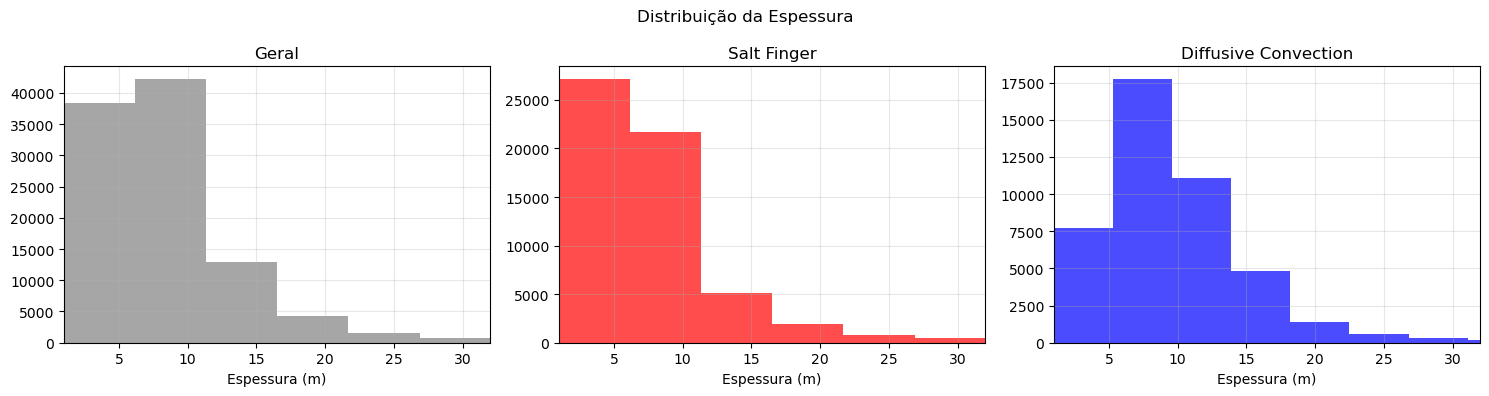

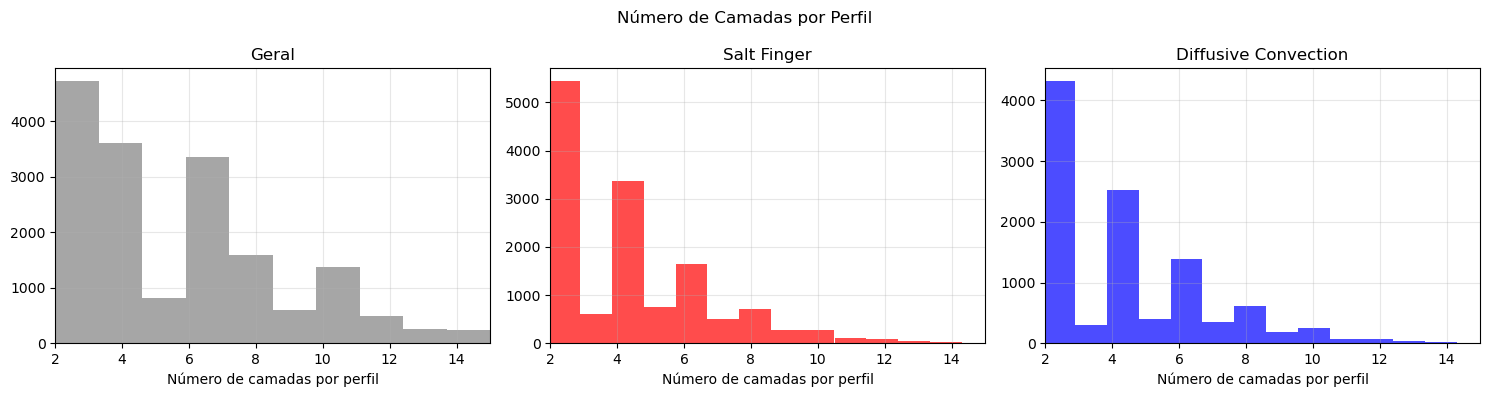

In [37]:
# FIGURA 2 — ESPESSURA E Nº CAMADAS
# =========================================================

plot_triplet(h_all, h_sf, h_dc,
             "Espessura (m)",
             "Distribuição da Espessura")

plot_triplet(n_all, n_sf, n_dc,
             "Número de camadas por perfil",
             "Número de Camadas por Perfil",
             bins=20)


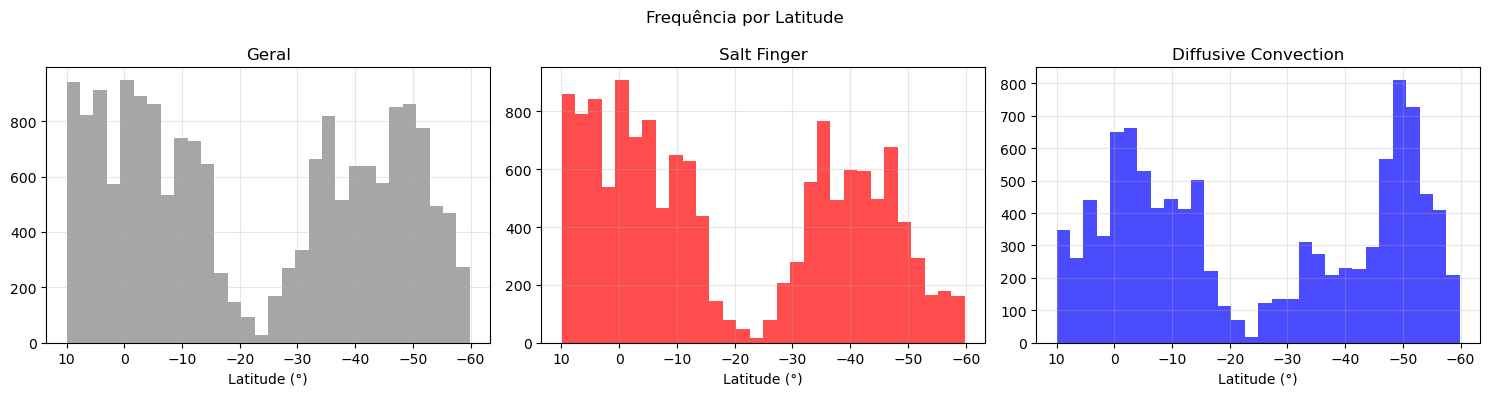

In [31]:
# FIGURA 3 — FREQUÊNCIA LATITUDINAL
# =========================================================

plot_triplet(lat_all, lat_sf, lat_dc,
             "Latitude (°)",
             "Frequência por Latitude",
             bins=30, invert=True)